This script takes a tfrecords file produced by "ralpn-make-dataset.ipynb" notebook and trains/tests a neural network for segmentation

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import IPython.display as display
from PIL import Image
import io
from matplotlib import colors
from matplotlib import pyplot as plt

In [2]:
# first load the dataset and figure out how big it is...
datasetFileName = 'ralpn_a.tfrecords'
dataset = tf.data.TFRecordDataset(datasetFileName)

In [3]:
# count number of examples in this dataset
# ideally we'd have already computed this and imported data as a tf.data.Dataset
# but just count the examples for now
numExamples = sum([1 for i in dataset])

In [4]:
# the tfrecords file is just a bunch of serialized images and classification masks ('labels')
# we need to convert these data back into images and make an actual dataset to be fed into the CNN
# mostly from: https://docs.microsoft.com/en-us/azure/databricks/_static/notebooks/deep-learning/mnist-tfrecords-to-tensorflow.html
# this is directly from the Kaggle notebook

# function to turn a 
#def _bytes_feature(value):
#  """Returns a bytes_list from a string / byte."""
#  if isinstance(value, type(tf.constant(0))):
#    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
#  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'seg_mask': tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

# convert images to tensors
def imageStringsToTensors(example):
    image_tensor    = tf.image.rgb_to_grayscale(tf.image.decode_png(example['image'], dtype=tf.dtypes.uint8))
    seg_mask_tensor = tf.image.rgb_to_grayscale(tf.image.decode_png(example['seg_mask'], dtype=tf.dtypes.uint8))
    image_tensor    = tf.image.resize(image_tensor, (512, 512))/255.0
    seg_mask_tensor = tf.image.resize(seg_mask_tensor, (512,512))
    image_tensor    = tf.squeeze(image_tensor)
    seg_mask_tensor = tf.cast(tf.squeeze(seg_mask_tensor),np.uint8)
    return image_tensor, seg_mask_tensor

# convert serialized dataset into a MapDataset with "image" and "class" features which are still byte strings
parsed_dataset = dataset.map(_parse_image_function)
parsed_dataset = parsed_dataset.map(imageStringsToTensors)
view_dataset = parsed_dataset # so we don't use up the iterator (may not be an issue? don't think MapDataset is an iterator?)
parsed_dataset

<MapDataset shapes: ((512, 512), (512, 512)), types: (tf.float32, tf.uint8)>

In [5]:
def apply_mask_to_image(image_arr,mask_arr):
    mask_colors = np.array([[0, 0, 0], [255,191,0], [0,255,0], [255,84,84], [84,84,255]])/255.0
    
    # image_arr comes in as a 512x512 matrix of float32 (?) values on [0,1]
    # we need to expand it to be a 512x512x3 RGB image of the same type and range
    image_arr = np.expand_dims(image_arr,2)
    image_arr = np.tile(image_arr,(1,1,3))
    
    # convert from RGB to HSV  (note: this could be done in tensorflow with tf.image.rgb_to_hsv)
    image_hsv_arr = colors.rgb_to_hsv(image_arr)
    
    # apply mask for each label class
    for labelIdx in range(5):
        
        # get label_mask
        label_mask = (mask_arr == labelIdx)
        
        # get color
        this_color_hsv = colors.rgb_to_hsv(mask_colors[labelIdx,:])
        
        # update hue
        image_hsv_arr[:,:,0] = image_hsv_arr[:,:,0] + np.multiply(this_color_hsv[0], label_mask)
        
        # update saturation
        image_hsv_arr[:,:,1] = image_hsv_arr[:,:,1] + np.multiply(this_color_hsv[1], label_mask)

    # convert back to RGB
    new_image =  colors.hsv_to_rgb(image_hsv_arr)
        
    # return masked image
    return new_image   

Image tensor shape:  (512, 512)
Segmentation mask tensor shape:  (512, 512)


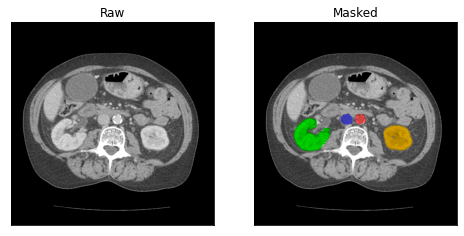

In [6]:
# look at an example image
for example in view_dataset.take(1):
    #print(example)
    print('Image tensor shape: ', example[0].shape)
    print('Segmentation mask tensor shape: ', example[1].shape)

    # extract image array
    image_arr = example[0].numpy()   #.squeeze() if necessary
     
    # extract label array, then produce masked image
    label_arr = example[1].numpy()   
    image_masked_arr = apply_mask_to_image(image_arr,label_arr)
    
    # some other methods of displaying images
    # note: display.Image != Image()... first is actually IPython.display.Image() and second is PIL.Image()
    # display.display(display.Image(data=tf.image.encode_png(image_arr).numpy(),width=200))   # easily resizable, but can't put images next to each other (automatic newline after each)
    # display.display(Image.fromarray(image_arr))   #### EASIEST WAY TO DISPLAY AN IMAGE FROM A NUMPY ARRAY!!!, BUT CAN'T SET DISPLAY SIZE? #########
    # Image.fromarray((image_masked_arr*255).astype(np.uint8),mode='RGB') # works for 512x512x3 RGB image, but can't resize?
    # Image.fromarray((image_arr*255).astype(np.uint8),mode='L') # works for 512x512 gray image, but can't resize?

    # display with matplotlib
    fig = plt.figure(figsize=(8,8))
    sp_axes = fig.subplots(1,2)
    sp_axes[0].imshow(image_arr,cmap='gray',vmin=0,vmax=1)
    sp_axes[0].get_xaxis().set_visible(False)
    sp_axes[0].get_yaxis().set_visible(False)
    sp_axes[0].set_title('Raw')
    
    sp_axes[1].imshow(image_masked_arr)
    sp_axes[1].get_xaxis().set_visible(False)
    sp_axes[1].get_yaxis().set_visible(False)
    sp_axes[1].set_title('Masked')    

    

In [7]:
# split into training and test sets
# https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
test_size = int(0.15 * numExamples)
val_size = int(0.15 * numExamples)
train_size = numExamples - (test_size + val_size)
full_dataset = parsed_dataset.shuffle(numExamples)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.take(test_size)
val_dataset = test_dataset.take(val_size)

In [8]:
#tf.data.experimental.cardinality(parsed_dataset)   # will return: tf.data.experimental.INFINITE_CARDINALITY
sum(1 for expmple in parsed_dataset)

360

In [9]:
train_size_true = sum(1 for expmple in train_dataset)
test_size_true = sum(1 for expmple in test_dataset)
val_size_true = sum(1 for expmple in val_dataset)
train_size_true + test_size_true + val_size_true

360

In [10]:
# try a bunch of stuff
myarr = np.array([[1,2],[3,4]])
print(myarr == 2)
myarr2 = np.multiply(myarr,(myarr==2))
print(myarr2)

for i in range(5):
    print(i)
    
    
myarr3d = np.array([ [[1,1],[1,1]], [[2,2],[2,2]], [[3,3],[3,3]] ])
print(myarr3d)
print(myarr3d.shape)
myarr3d_slice = myarr3d[0,:,:]

print(myarr3d_slice)

mycolors = np.array([[0, 0, 0], [255,191,255], [0,255,0], [255,84,84], [84,84,255]])
print(mycolors[1,:])
print(colors.rgb_to_hsv(mycolors[1,:]))

myarr2d = myarr3d[0,:,:] + myarr3d[1,:,:]
print(myarr2d)

np.ones((4,4))
np.ones(myarr2d.shape)

[[False  True]
 [False False]]
[[0 2]
 [0 0]]
0
1
2
3
4
[[[1 1]
  [1 1]]

 [[2 2]
  [2 2]]

 [[3 3]
  [3 3]]]
(3, 2, 2)
[[1 1]
 [1 1]]
[255 191 255]
[8.33333333e-01 2.50980392e-01 2.55000000e+02]
[[3 3]
 [3 3]]


array([[1., 1.],
       [1., 1.]])

In [11]:
myarr = np.array([[1,2],[3,4]])
newArr = np.expand_dims(myarr,2)
newArr = np.tile(newArr,(1,1,3))
print('Shape:', np.shape(newArr),'\n')
print(newArr[:,:,0],'\n')
print(newArr[:,:,1],'\n')
print(newArr[:,:,2],'\n')

Shape: (2, 2, 3) 

[[1 2]
 [3 4]] 

[[1 2]
 [3 4]] 

[[1 2]
 [3 4]] 



In [12]:
myarr2d = np.array([[1,2],[3,4]])
print(myarr2d)
myarr2d[0,:] = myarr2d[0,:] + np.ones(myarr2d[0,:].shape)
print(myarr2d)

red = np.array([255,0,0])
print(red)
red_hsv = colors.rgb_to_hsv(red/255.0)
print(red_hsv)

[[1 2]
 [3 4]]
[[2 3]
 [3 4]]
[255   0   0]
[0. 1. 1.]
